## Importations

In [1]:
## pour tracer les figures :
import matplotlib.pyplot as plt
from matplotlib import rc

##
import numpy as np

import sys
sys.path.append('../')

## ML :
from scripts.machine_learning_utils import *
from scripts.models import *

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import KFold

import pandas as pd



rc('font', family='sans-serif', size = 7)
rc('figure', dpi= 700)
rc(('xtick', 'ytick'), labelsize = 7)
rc('legend', fontsize=6)
rc('lines', linewidth = 1)
rc('axes', linewidth = 0.5, labelsize =8)
rc('legend', handlelength = 2)

## Get data

In [2]:
df_total = pd.read_csv('csv/nrj_data/df_total.csv').set_index('SMILES')
df_total = df_total.drop('N#Cc1c2c(cc(C(F)(F)F)c1C(F)(F)F)N1B(O2)Oc2c1cc(C(F)(F)F)c(C(F)(F)F)c2C#N')
df_total = df_total.drop('Cc1c(Br)c(Br)c(B(c2c(Br)c(Br)c(C)c(Br)c2Br)c2c(Br)c(Br)c(C)c(Br)c2Br)c(Br)c1Br')
df_Ohmiya = df_total[df_total.group == 'Ohmiya']
df_ONO = df_total[df_total.group == 'ONO']

df_NNN = df_total[df_total.group == 'NNN']
df_triarylboranes = df_total[df_total.group == "triarylboranes"]

In [3]:
## poure les descirpteurs quantiques 
df_atom1 = pd.read_csv('csv/df_atom1_ext.csv').set_index("can")
df_global = pd.read_csv('csv/df_global_ext.csv').set_index("can")
print('should be 19 :', df_atom1.shape[1])
print('should be 24 :', df_global.shape[1])

data_Q_tot = {}

data_Q_tot['global']=df_global

data_Q_tot['atom1']=df_atom1

should be 19 : 19
should be 24 : 24


In [4]:
df_sigman = pd.read_excel('csv/descriptors/sub_descriptors_sigman.xlsx', sheet_name = ['ortho','meta', 'para'])

## Fonctions utiles

In [5]:
def reduce_descr(S, descriptors, names, reduced_features):
    if S == 'ONO':
        X = create_descriptors(df_ONO.index, descriptors, data = data_Q_tot, structure = S)
        df_X = pd.DataFrame(X)
        df_X.columns = names
        df_X_reduced = df_X.loc[:,reduced_features]
        X_reduced = np.array(df_X_reduced)
        Y = df_ONO.FIA
    if S == 'NNN':
        X = create_descriptors(df_NNN.index, descriptors, data = data_Q_tot, structure = S)
        df_X = pd.DataFrame(X)
        df_X.columns = names
        df_X_reduced = df_X.loc[:,reduced_features]
        X_reduced = np.array(df_X_reduced)
        Y = df_NNN.FIA
    if S == 'Ohmiya':
        X = create_descriptors(df_Ohmiya.index, descriptors, data = data_Q_tot, structure = S)
        df_X = pd.DataFrame(X)
        df_X.columns = names
        df_X_reduced = df_X.loc[:,reduced_features]
        X_reduced = np.array(df_X_reduced)
        Y = df_Ohmiya.FIA
    if S == 'triarylboranes':
        X = create_descriptors(df_triarylboranes.index, descriptors, data = data_Q_tot, structure = S)
        df_X = pd.DataFrame(X)
        df_X.columns = names
        df_X_reduced = df_X.loc[:,reduced_features]
        X_reduced = np.array(df_X_reduced)
        Y = df_triarylboranes.FIA 
        
    return(X, X_reduced, Y)

def get_names(descriptors):
    
    if descriptors == 'rdkit':
        names = []
        for desc_name, function in Descriptors.descList :
            names.append(desc_name)
            
    elif descriptors == 'quantum':
        names = np.concatenate((data_Q_tot['global'].columns.to_list(), data_Q_tot['atom1'].columns.to_list()))
        
    elif descriptors == "sigman":
        names = list(np.concatenate((df_sigman['ortho'].set_index('R-ortho').columns.to_list(), df_sigman['meta'].set_index('R-meta').columns.to_list(), df_sigman['para'].set_index('R-para').columns.to_list())))
    
    return(names)

## Evaluate models without feature selection

In [6]:
structures = ['ONO', 'NNN', 'OCO', 'triarylboranes']

df_results = pd.DataFrame(columns = structures, index=structures)

In [7]:
df_results

ONO  NNN  OCO triarylboranes
ONO             NaN  NaN  NaN            NaN
NNN             NaN  NaN  NaN            NaN
OCO             NaN  NaN  NaN            NaN
triarylboranes  NaN  NaN  NaN            NaN

In [6]:
def df(S):
    if S == 'ONO':
        return df_ONO
    if S == 'NNN':
        return df_NNN
    if S == 'Ohmiya':
        return df_Ohmiya
    if S == 'triarylboranes':
        return df_triarylboranes


In [11]:
descriptors = "rdkit"
model = 'Ridge'

for S1 in structures :
    X_S1 = create_descriptors(df(S1).index, descriptors, data = data_Q_tot, structure = S1)
    Y_S1 = df(S1).FIA
    for S2 in structures :
        if S2 == S1 :
            total_Y_S_test, total_Y_S_pred_test, list_MAE_S = K_Fold_model_evaluation(dict_models[model][descriptors],
                                                                                      X_S1,Y_S1,n_fold=10, n_repet=5)
            z = np.polyfit(total_Y_S_test, total_Y_S_pred_test, 1)
            df_results[S1][S2]=f'MAE = {round(np.mean(list_MAE_S),2)} \na = {round(z[0],2)} \nb = {round(z[1],2)}'
        else :
            X_S2 = create_descriptors(df(S2).index, descriptors, data = data_Q_tot, structure = S2)
            Y_S2 = df(S2).FIA
            Y_pred_S2_train_S1, MAE_S1_S2 = train_predict(X_S1, X_S2, Y_S1, Y_S2, dict_models[model][descriptors])
            z = np.polyfit(Y_S2, Y_pred_S2_train_S1, 1)
            df_results[S1][S2]=f'MAE = {round(MAE_S1_S2,2)} \na = {round(z[0],2)} \nb = {round(z[1],2)}'
            
    

In [14]:
df_results.to_excel('article/tables/extrapolating_results_without_feature_selection_rdkit_ridge.xlsx')

In [12]:
df_results

ONO  \
ONO                   MAE = 6.92 \na = 0.97 \nb = 13.26   
NNN             MAE = 1828.25 \na = 0.86 \nb = -1782.77   
OCO             MAE = 1011.78 \na = 1.04 \nb = -1023.82   
triarylboranes  MAE = 3481.39 \na = 0.61 \nb = -3328.38   

                                                    NNN  \
ONO               MAE = 4264.77 \na = 1.0 \nb = 4262.97   
NNN                   MAE = 10.6 \na = 0.95 \nb = 14.95   
OCO              MAE = 2209.28 \na = 0.97 \nb = 2218.53   
triarylboranes  MAE = 4905.19 \na = 9.32 \nb = -8136.79   

                                                     OCO  \
ONO                MAE = 3192.5 \na = 0.61 \nb = 3345.53   
NNN              MAE = 3991.11 \na = 0.56 \nb = -3851.48   
OCO                    MAE = 9.73 \na = 0.89 \nb = 37.29   
triarylboranes  MAE = 9334.76 \na = -0.91 \nb = -8593.08   

                                     triarylboranes  
ONO              MAE = 60.95 \na = 0.65 \nb = 87.93  
NNN             MAE = 34.24 \na = 0.59 \nb = 106.98  
OCO             MAE = 55.17 \na = 0.85 \nb = 107.16  
triarylboranes   MAE = 31.54 \na = 0.75 \nb = 97.06

#### ONO > NNN

In [30]:
df_model_NNN = pd.DataFrame(columns = dict_models.keys())

In [32]:
S1='ONO'
S2 = 'NNN'

X_S1 = create_descriptors(df(S1).index, descriptors, data = data_Q_tot, structure = S1)
X_S2 = create_descriptors(df(S2).index, descriptors, data = data_Q_tot, structure = S2)
Y_S1 = df(S1).FIA
Y_S2 = df(S2).FIA

In [35]:
for model in df_model_NNN.columns :
    Y_pred_S2_train_S1, MAE_S1_S2 = train_predict(X_S1, X_S2, Y_S1, Y_S2, dict_models[model][descriptors])
    z = np.polyfit(Y_S2, Y_pred_S2_train_S1, 1)
    df_model_NNN.at["performance",model]=f'MAE = {round(MAE_S1_S2,2)} \na = {round(z[0],2)} \nb = {round(z[1],2)}'

In [36]:
df_model_NNN

Linear  \
performance  MAE = 51.68 \na = 0.89 \nb = -15.86   

                                           Ridge  \
performance  MAE = 189.97 \na = 0.88 \nb = 228.8   

                                     Bayes. Ridge  \
performance  MAE = 227.28 \na = 0.88 \nb = 266.46   

                                            Lasso  \
performance  MAE = 163.64 \na = 0.88 \nb = 200.85   

                                            SVR  \
performance  MAE = 86.49 \na = 0.86 \nb = 130.1   

                                            Tree  \
performance  MAE = 76.57 \na = 0.81 \nb = 135.78   

                                              RF  \
performance  MAE = 71.71 \na = 0.81 \nb = 130.79   

                                              GB  \
performance  MAE = 70.52 \na = 0.74 \nb = 151.27   

                                            GPR  \
performance  MAE = 86.42 \na = 0.0 \nb = 396.67   

                                             KNN  \
performance  MAE = 60.18 \na = 0.45 \nb = 231.26   

                                           MLP  
performance  MAE = 21.93 \na = 0.89 \nb = 16.4

In [39]:
df_model_NNN.to_excel('article/tables/extrapolating_results_without_feature_selection_ONO-NNN.xlsx')

### Extrapolation without selecting features by including the mean value of FIA during training. 

### Extrapolation training on different structures so that the model can learn the difference

In [65]:
df_train = df_total[(df_total.group == 'ONO') | (df_total.group == 'Ohmiya') | (df_total.group=='triarylboranes') ]

In [66]:
df_test = df_NNN

In [67]:
descriptors = 'quantum'

X_train = create_descriptors(df_train.index, descriptors, data= data_Q_tot)
Y_train = df_train.FIA

X_test = create_descriptors(df_test.index, descriptors, data=data_Q_tot)
Y_test = df_test.FIA

In [68]:
model = 'Ridge'
Y_pred, MAE = train_predict(X_train, X_test, Y_train, Y_test, dict_models[model][descriptors])

In [69]:
MAE

35.67680037698121

In [41]:
L= ['ONO', 'NNN']
L.remove('ONO')

In [42]:
L

['NNN']

#### Automate

In [8]:
model = 'Ridge'
descriptors = 'quantum'

In [73]:
df_training_3_str = pd.DataFrame(columns = ['ONO', 'NNN', 'Ohmiya', 'triarylboranes'])

for structure in df_training_3_str.columns:
    print(structure)
    #S_test = structure
    L = list(df_training_3_str.columns)
    L.remove(structure)
    S_train_1, S_train_2, S_train_3 = L[0], L[1], L[2]
    print("training structure are", S_train_1, S_train_2, S_train_3)
    df_train = df_total[(df_total.group == S_train_1) | (df_total.group == S_train_2) | (df_total.group==S_train_3)]
    df_test = df(structure)
    X_train = create_descriptors(df_train.index, descriptors, data= data_Q_tot)
    Y_train = df_train.FIA

    X_test = create_descriptors(df_test.index, descriptors, data=data_Q_tot)
    Y_test = df_test.FIA
    Y_pred, MAE = train_predict(X_train, X_test, Y_train, Y_test, dict_models[model][descriptors])
    
    z = np.polyfit(Y_test, Y_pred, 1)
    df_training_3_str.at["performance",structure]=f'MAE = {round(MAE,2)} \na = {round(z[0],2)} \nb = {round(z[1],2)}'

ONO
training structure are NNN Ohmiya triarylboranes
NNN
training structure are ONO Ohmiya triarylboranes
Ohmiya
training structure are ONO NNN triarylboranes
triarylboranes
training structure are ONO NNN Ohmiya


In [78]:
df_training_3_str.to_excel('article/tables/extrapolation_performances_3_structures_training.xlsx')

In [9]:
df_training_2_str = pd.DataFrame(columns = ['ONO', 'NNN', 'Ohmiya'])

for structure in df_training_2_str.columns:
    print(structure)
    #S_test = structure
    L = list(df_training_2_str.columns)
    L.remove(structure)
    S_train_1, S_train_2 = L[0], L[1]
    print("training structure are", S_train_1, S_train_2)
    df_train = df_total[(df_total.group == S_train_1) | (df_total.group == S_train_2)]
    df_test = df(structure)
    X_train = create_descriptors(df_train.index, descriptors, data= data_Q_tot)
    Y_train = df_train.FIA

    X_test = create_descriptors(df_test.index, descriptors, data=data_Q_tot)
    Y_test = df_test.FIA
    Y_pred, MAE = train_predict(X_train, X_test, Y_train, Y_test, dict_models[model][descriptors])
    
    z = np.polyfit(Y_test, Y_pred, 1)
    df_training_2_str.at["performance",structure]=f'MAE = {round(MAE,2)} \na = {round(z[0],2)} \nb = {round(z[1],2)}'

ONO
training structure are NNN Ohmiya
NNN
training structure are ONO Ohmiya
Ohmiya
training structure are ONO NNN


In [10]:
df_training_2_str 

ONO  \
performance  MAE = 42.53 \na = 0.92 \nb = -11.72   

                                            NNN  \
performance  MAE = 83.48 \na = 0.9 \nb = -52.36   

                                          Ohmiya  
performance  MAE = 45.28 \na = 0.91 \nb = -13.13

In [11]:
df_training_2_str.to_excel('article/tables/extrapolation_performances_2_structures_training_not_triarylboranes.xlsx')

In [52]:
L = list(df_training_3_str.columns)

In [54]:
L.remove('ONO')

In [61]:
df('ONO').index

Index(['Brc1cc(Br)c2c(c1)N1B(O2)Oc2c(Br)cc(Br)cc21',
       'Brc1ccc2c(c1)N1B(O2)Oc2ccc(Br)cc21',
       'Brc1ccc2c(c1)OB1Oc3cc(Br)ccc3N12',
       'Brc1ccc2c(c1Br)OB1Oc3c(ccc(Br)c3Br)N12',
       'Brc1cccc2c1OB1Oc3c(Br)cccc3N12',
       'CC(C)(C)c1c(C#N)c(C#N)cc2c1OB1Oc3c(cc(C#N)c(C#N)c3C(C)(C)C)N12',
       'CC(C)(C)c1c(C(F)(F)F)cc2c(c1N)OB1Oc3c(cc(C(F)(F)F)c(C(C)(C)C)c3N)N12',
       'CC(C)(C)c1c(F)c(Br)cc2c1OB1Oc3c(cc(Br)c(F)c3C(C)(C)C)N12',
       'CC(C)(C)c1c(F)ccc2c1OB1Oc3c(ccc(F)c3C(C)(C)C)N12',
       'CC(C)(C)c1c(N)cc2c(c1[N+](=O)[O-])OB1Oc3c(cc(N)c(C(C)(C)C)c3[N+](=O)[O-])N12',
       ...
       'Oc1cc2c(c(Cl)c1O)OB1Oc3c(cc(O)c(O)c3Cl)N12',
       'Oc1cc2c(c(O)c1C(F)(F)F)OB1Oc3c(cc(O)c(C(F)(F)F)c3O)N12',
       'Oc1cc2c(c(O)c1F)OB1Oc3c(cc(O)c(F)c3O)N12',
       'Oc1cc2c(cc1C(F)(F)F)OB1Oc3cc(C(F)(F)F)c(O)cc3N12',
       'Oc1cc2c(cc1Cl)N1B(O2)Oc2cc(O)c(Cl)cc21',
       'Oc1cc2c(cc1Cl)OB1Oc3cc(Cl)c(O)cc3N12',
       'Oc1ccc2c(c1)N1B(O2)Oc2ccc(O)cc21', 'Oc1ccc2c(c1)OB1Oc3cc(O)cc

### Correlations

Create a table of quantum descriptors (features = columns) for each molecule (row)

In [6]:
descriptors = 'quantum'
names = get_names(descriptors)

In [7]:
X_total = create_descriptors(df_total.index, descriptors, data = data_Q_tot)
df_X_total = pd.DataFrame(X_total)

In [8]:
df_X_total.columns = names

In [11]:
df_X_total['FIA']= list(df_total.FIA)

In [14]:
L=list(df_X_total.corr("spearman")['FIA'].drop('FIA'))
df_correlation = pd.DataFrame()
df_correlation['features']= names
df_correlation['corr with FIA']= [np.round(abs(x),3) for x in L]


In [15]:
df = df_correlation.set_index('features').sort_values('corr with FIA', ascending = False)

In [16]:
df.to_excel('article/tables/quantum_features_correlation_with_FIA.xlsx')

### Features that vary a lot between molecular structures

In [17]:
## create descriptors
X_ONO = create_descriptors(df_ONO.index, descriptors, data = data_Q_tot)
X_NNN = create_descriptors(df_NNN.index, descriptors, data = data_Q_tot)
X_Ohmiya = create_descriptors(df_Ohmiya.index, descriptors, data = data_Q_tot)

## convert descriptors to dataframes

df_X_ONO = pd.DataFrame(X_ONO)
df_X_NNN = pd.DataFrame(X_NNN)
df_X_Ohmiya = pd.DataFrame(X_Ohmiya)

df_X_ONO.columns = names
df_X_NNN.columns = names
df_X_Ohmiya.columns = names

In [19]:
df_mean = pd.DataFrame() ## create a table of mean feature value for each structure ONO and NNN
df_mean["NNN"] = list(df_X_NNN.mean())
df_mean["ONO"] = list(df_X_ONO.mean())
df_mean.index = names

In [20]:
## to get the features that vary the most from one structure to another
df_mean['deviation']= np.round(abs((df_mean['NNN']-df_mean['ONO'])/((df_mean['NNN']+df_mean['ONO'])/2)),3)
df_mean = df_mean.dropna()
df_mean_sorted = df_mean.sort_values('deviation', ascending = False)
df_mean_sorted.to_excel('article/tables/table_SI_quantum_NNN_ONO_mean_features.xlsx')

In [21]:
df_mean_sorted

NNN           ONO  deviation
X                                     -0.000     -0.000823      2.000
lumo_energy                           -0.002     -0.010458      1.358
Z                                     -0.010     -0.003291      1.010
NPA_Rydberg                            0.016      0.029452      0.592
ES_root_NPA_Rydberg                    0.017      0.029911      0.550
NMR_anisotropy                        16.345     11.588144      0.341
dipole                                 4.841      3.584069      0.298
Y                                     -0.538     -0.689481      0.247
ES_root_NPA_charge                     1.045      1.280722      0.203
NPA_charge                             1.048      1.257998      0.182
APT_charge                             1.067      1.254390      0.161
ES_root_dipole                         4.674      3.996047      0.156
ES_root_NPA_valence                    1.940      1.690532      0.137
NPA_valence                            1.937      1.713723      0.122
G_thermal_correction                   0.255      0.231147      0.098
zero_point_correction                  0.308      0.282748      0.085
E_thermal_correction                   0.331      0.304772      0.083
H_thermal_correction                   0.332      0.305716      0.082
electronegativity                      0.127      0.137669      0.081
ES_root_NPA_total                      3.955      3.719278      0.061
number_of_atoms                       40.918     38.485294      0.061
NPA_total                              3.952      3.742003      0.055
homo_energy                           -0.252     -0.264879      0.050
H                                  -2440.757  -2541.185088      0.040
electronic_spatial_extent          13522.813  12986.664781      0.040
E_scf                              -2440.941  -2541.329705      0.040
E_zpe                              -2440.781  -2541.208057      0.040
G                                  -2440.833  -2541.259658      0.040
E                                  -2440.758  -2541.186032      0.040
NMR_shift                             89.842     86.464838      0.038
ES_root_molar_volume                2671.401   2588.301140      0.032
molar_volume                        2688.979   2605.689691      0.031
ES_root_electronic_spatial_extent  13768.427  13392.655851      0.028
VBur                                   0.605      0.590266      0.025
ES_root_Mulliken_charge                0.670      0.683433      0.020
hardness                               0.125      0.127210      0.018
molar_mass                           395.729    390.019660      0.015
Mulliken_charge                        0.668      0.667453      0.001
converged                              1.000      1.000000      0.000
ES_root_NPA_core                       1.999      1.998835      0.000
NPA_core                               1.999      1.998828      0.000
multiplicity                           1.000      1.000000      0.000

### Recursive feature selection

In [188]:
## find the features that deviates the slope and/or that add a bias

descriptors = 'sigman'
model = dict_models['Ridge'][descriptors]

X_ONO = create_descriptors(df_ONO.index, descriptors, data = data_Q_tot, structure = 'ONO')
X_NNN = create_descriptors(df_NNN.index, descriptors, data = data_Q_tot, structure = 'NNN')
Y_ONO = df_ONO.FIA
Y_NNN = df_NNN.FIA

names = get_names(descriptors)

df_X_ONO = pd.DataFrame(X_ONO)
df_X_ONO.columns=names
df_X_NNN = pd.DataFrame(X_NNN)
df_X_NNN.columns=names

all_features = names[:]






print('nb of starting features :', len(feature_names))


# on peut raffiner successivement en éliminant les features 
# trouvées au dernier lancement de l'algo

features_to_rm = []

for feature in all_features :
    #print(feature)

    reduced_features = all_features[:]
    reduced_features.remove(feature)
    

    df_X_ONO_reduced = df_X_ONO.loc[:,reduced_features]
    X_ONO_reduced = np.array(df_X_ONO_reduced)

    df_X_NNN_reduced = df_X_NNN.loc[:,reduced_features]
    X_NNN_reduced = np.array(df_X_NNN_reduced)
    
    X_train, X_test, Y_train, Y_test = X_ONO_reduced, X_NNN_reduced, Y_ONO, Y_NNN
    Y_pred_test,  MAE = train_predict(X_train, X_test, Y_train, Y_test, model)
    
    FIA_calc_NNN_train_ONO = Y_test
    FIA_pred_NNN_train_ONO = Y_pred_test
    z = np.polyfit(FIA_calc_NNN_train_ONO, FIA_pred_NNN_train_ONO, 1)
    pente = z[0]
    b = z[1]
    
    #if -100< b < 100 and 0.2 < pente < 2:
    if MAE < 86:
        #print(reduced_features)
        features_to_rm.append(feature)
        
        
        
        FIA_calc_ONO, FIA_pred_ONO, list_MAE_ONO = K_Fold_model_evaluation(model,X_ONO_reduced,Y_ONO,n_fold=10, n_repet=5)
        
        
        FIA_calc_NNN, FIA_pred_NNN, list_MAE_NNN = K_Fold_model_evaluation(model,X_NNN_reduced,Y_NNN,n_fold=10, n_repet=5)

        p = np.poly1d(z)
        
        S1 = 'ONO'
        S2 = 'NNN'
        
        print(feature)
        print(f"MAE {S1} = {round(np.mean(list_MAE_ONO),2)}")
        print(f"MAE {S2} = {round(np.mean(list_MAE_NNN),2)}")
        print(f"MAE {S1}->{S2} = {round(MAE,2)}")
        
        plt.scatter(x=FIA_calc_NNN_train_ONO, y=FIA_pred_NNN_train_ONO,c = 'purple', s = 80, alpha=0.3, label='S2 trained on S1')
        
        plt.plot(FIA_calc_NNN_train_ONO,p(FIA_calc_NNN_train_ONO),"#F8766D", label = f"fit $y=a \cdot x+b$ \na = {round(z[0],2)} \nb = {round(z[1],2)}")
        plt.tight_layout()
        plt.legend()
        plt.show()
        
print(features_to_rm)

nb of starting features : 36
[]


### Test selected features

#### Quantum descriptors

In [9]:
reduced_features = ['E', 'ES_root_dipole', 'ES_root_electronic_spatial_extent', 'E_scf', 'E_thermal_correction', 'E_zpe', 'G', 'G_thermal_correction', 'H', 'H_thermal_correction', 'electronegativity', 'electronic_spatial_extent', 'hardness', 'homo_energy', 'molar_mass', 'number_of_atoms', 'zero_point_correction', 'APT_charge', 'ES_root_Mulliken_charge', 'ES_root_NPA_Rydberg', 'ES_root_NPA_charge', 'ES_root_NPA_core', 'ES_root_NPA_total', 'ES_root_NPA_valence', 'Mulliken_charge', 'NMR_anisotropy', 'NMR_shift', 'NPA_core', 'NPA_total', 'NPA_valence']

In [10]:
descriptors = "quantum"
S1 = 'ONO'
S2 = 'NNN'

names = get_names(descriptors)



## create descriptors

X_S1, X_S1_reduced, Y_S1 = reduce_descr(S1, descriptors, names, reduced_features)
X_S2, X_S2_reduced, Y_S2 = reduce_descr(S2, descriptors, names, reduced_features)

In [11]:
np.shape(X_S1)

(272, 43)

In [12]:
model = 'Lasso'

reduced = 'False'

def gene_X_S1(reduced):
    if reduced == 'True':
        return(X_S1_reduced)
    else :
        return(X_S1)

def gene_X_S2(reduced):
    if reduced == 'True':
        return(X_S2_reduced)
    else :
        return(X_S2)
       
X_S1_extr = gene_X_S1(reduced)
X_S2_extr = gene_X_S2(reduced)

total_Y_S1_test, total_Y_S1_pred_test, list_MAE_S1 = K_Fold_model_evaluation(dict_models[model][descriptors],X_S1_extr,Y_S1,n_fold=10, n_repet=5)
total_Y_S2_test, total_Y_S2_pred_test, list_MAE_S2 = K_Fold_model_evaluation(dict_models[model][descriptors],X_S2_extr,Y_S2,n_fold=10, n_repet=5)


#extrapolation avec les features reduced

Y_pred_S2_train_S1, MAE_S1_S2 = train_predict(X_S1_extr, X_S2_extr, Y_S1, Y_S2, dict_models[model][descriptors])

print(f"MAE {S1} = {round(np.mean(list_MAE_S1),2)}")
print(f"MAE {S2} = {round(np.mean(list_MAE_S2),2)}")
print(f"MAE {S1}->{S2} = {round(MAE_S1_S2,2)}")

MAE ONO = 7.55
MAE NNN = 11.8
MAE ONO->NNN = 163.64


In [ ]:
model = 'Lasso'

reduced = 'True'

def gene_X_S1(reduced):
    if reduced == 'True':
        return(X_S1_reduced)
    else :
        return(X_S1)

def gene_X_S2(reduced):
    if reduced == 'True':
        return(X_S2_reduced)
    else :
        return(X_S2)
       
X_S1_extr = gene_X_S1(reduced)
X_S2_extr = gene_X_S2(reduced)

total_Y_S1_test_reduced, total_Y_S1_pred_test_reduced, list_MAE_S1 = K_Fold_model_evaluation(dict_models[model][descriptors],X_S1_extr,Y_S1,n_fold=10, n_repet=5)
total_Y_S2_test_reduced, total_Y_S2_pred_test_reduced, list_MAE_S2 = K_Fold_model_evaluation(dict_models[model][descriptors],X_S2_extr,Y_S2,n_fold=10, n_repet=5)


#extrapolation avec les features reduced

Y_pred_S2_train_S1_reduced, MAE_S1_S2 = train_predict(X_S1_extr, X_S2_extr, Y_S1, Y_S2, dict_models[model][descriptors])

print(f"MAE {S1} = {round(np.mean(list_MAE_S1),2)}")
print(f"MAE {S2} = {round(np.mean(list_MAE_S2),2)}")
print(f"MAE {S1}->{S2} = {round(MAE_S1_S2,2)}")

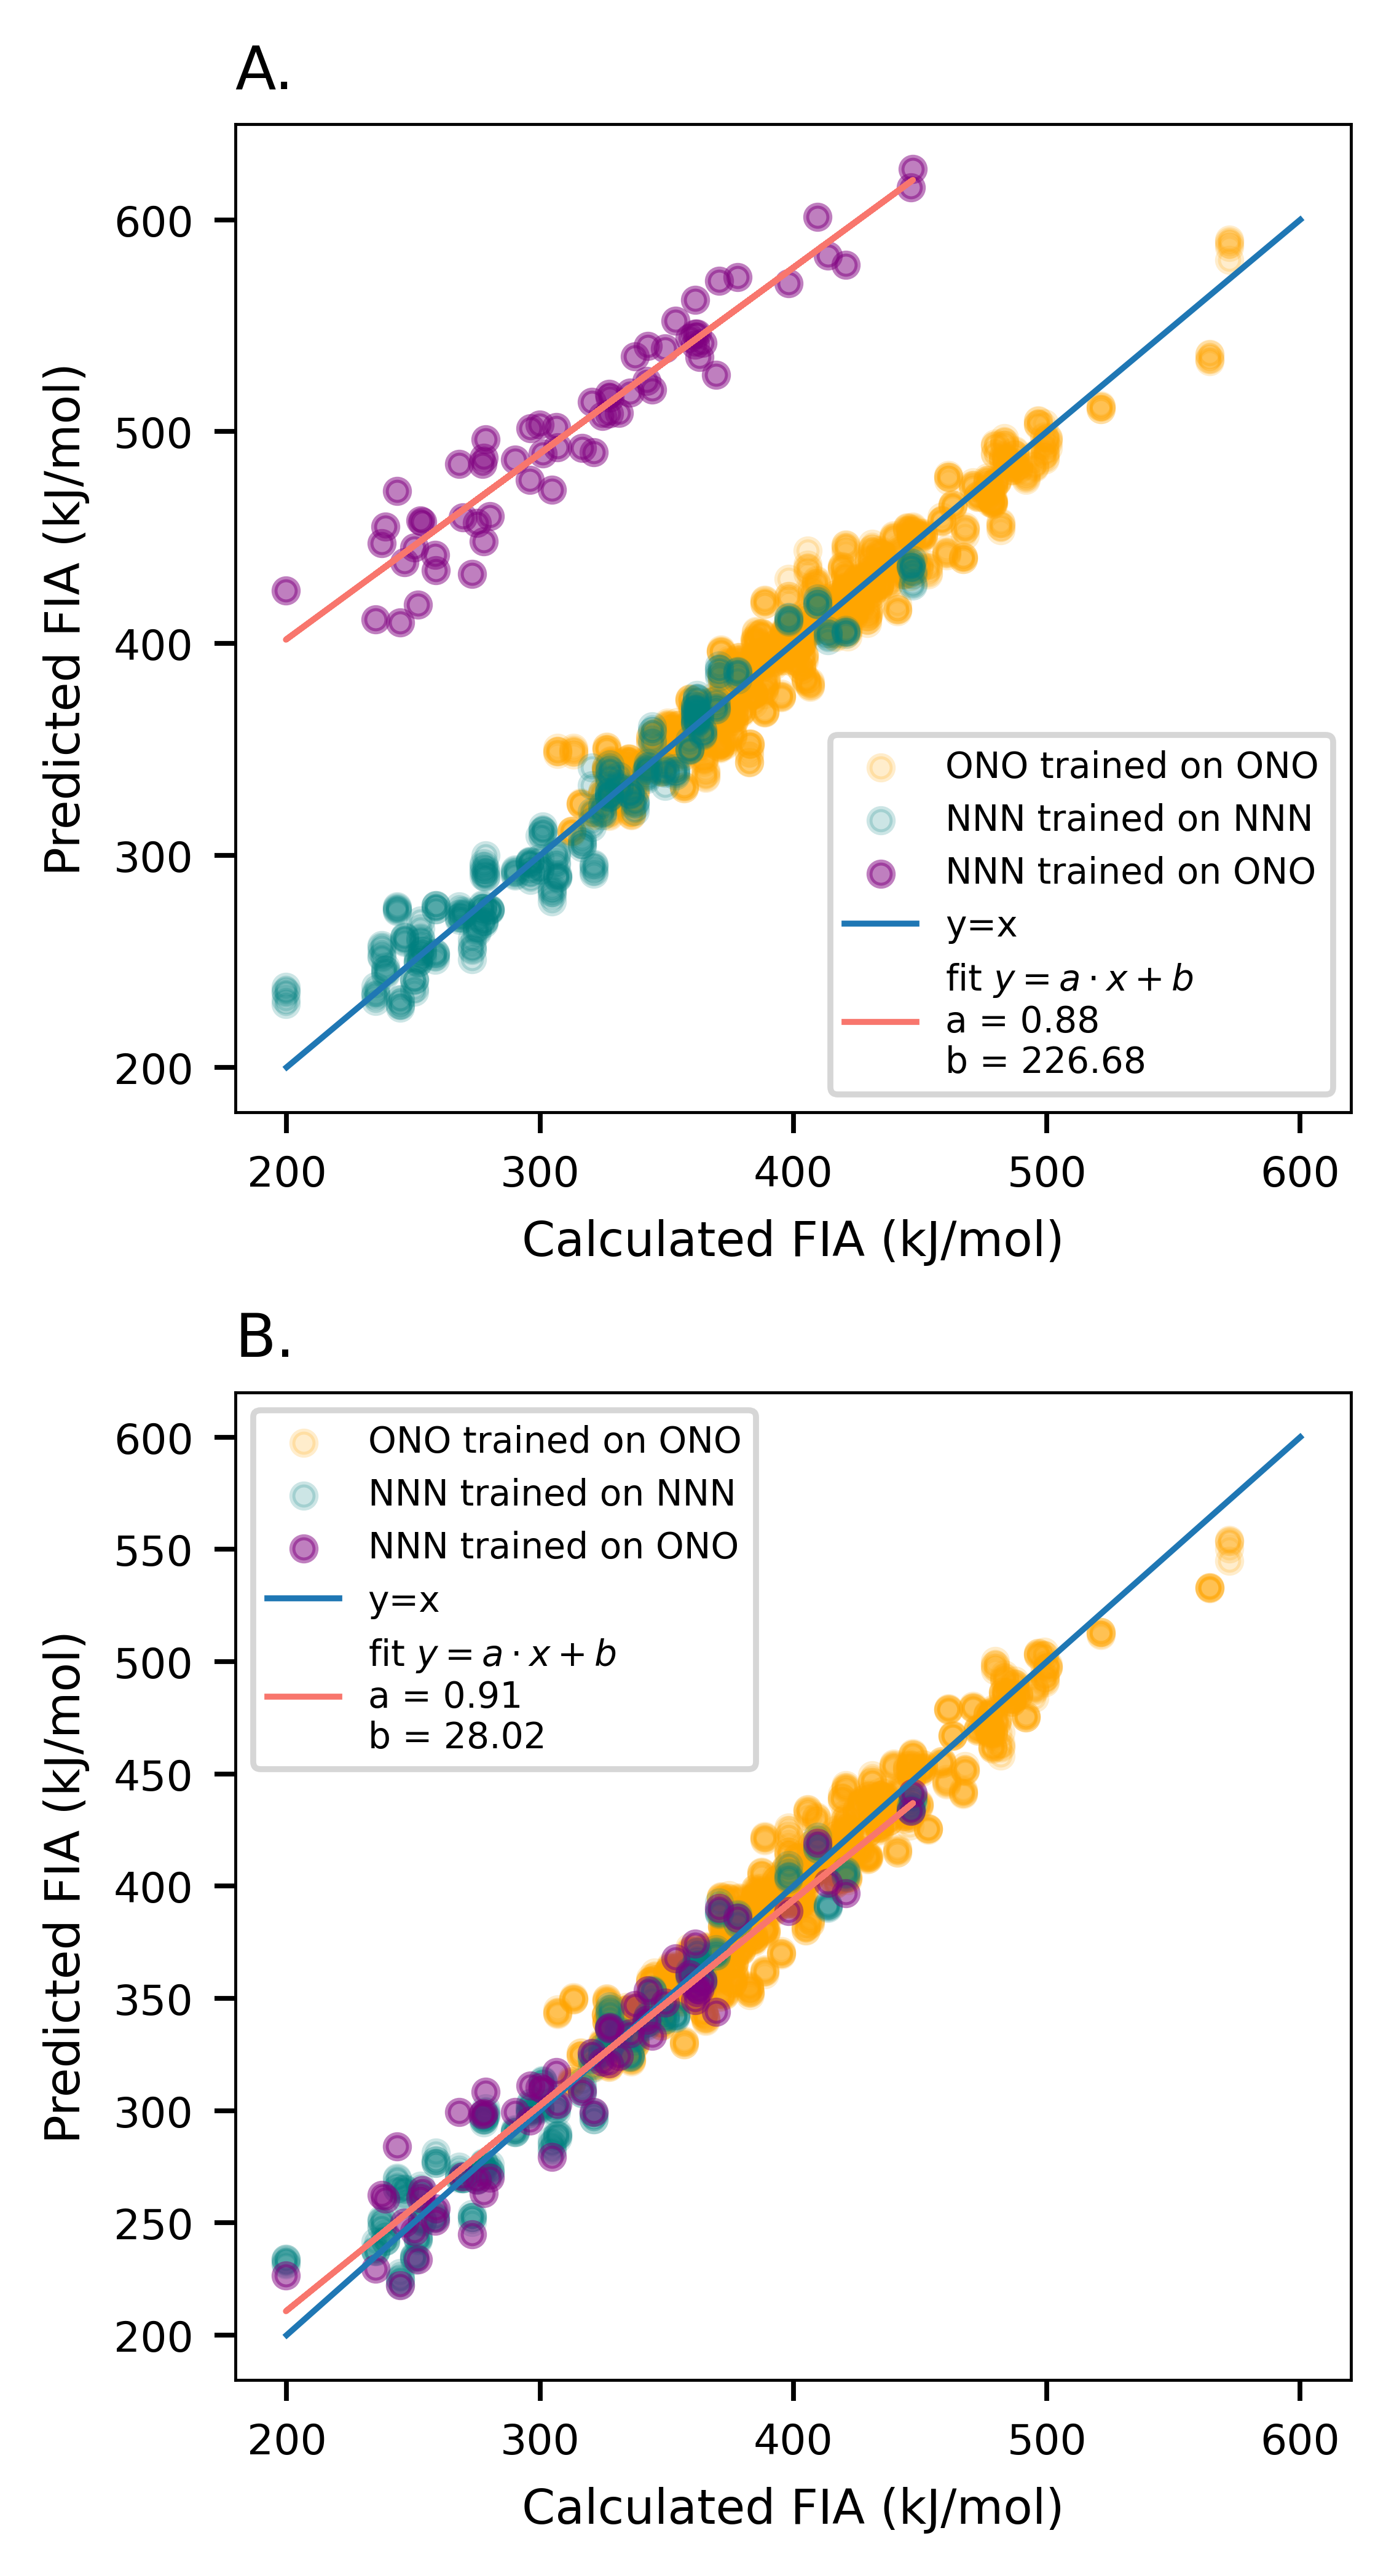

In [33]:
## plot 
fig = plt.figure(figsize=(3.25, 6))

ax1 = plt.subplot2grid((2, 1), (0, 0))

ax2 = plt.subplot2grid((2, 1), (1, 0))


## 1st graph

ax1.scatter(x=total_Y_S1_test, y=total_Y_S1_pred_test, s = 15, c="orange", alpha=0.2, label =f'{S1} trained on {S1}')
ax1.scatter(x=total_Y_S2_test, y=total_Y_S2_pred_test, s = 15, c="teal", alpha=0.2, label=f'{S2} trained on {S2}')
ax1.scatter(x=Y_S2, y=Y_pred_S2_train_S1,c = 'purple', s = 15, alpha=0.5, label=f'{S2} trained on {S1}')
#plt.scatter(x = FIA_ONO_reduced, y = FIA_ONO_reduced, s = 80, c='g')
intervalle = np.linspace(200, 600, 100)
ax1.plot(intervalle, intervalle, label = "y=x")

z = np.polyfit(Y_S2, Y_pred_S2_train_S1, 1)
p = np.poly1d(z)
    
ax1.plot(Y_S2,p(Y_S2),"#F8766D", label = f"fit $y=a \cdot x+b$ \na = {round(z[0],2)} \nb = {round(z[1],2)}")

ax1.set_ylabel('Predicted FIA (kJ/mol)')
ax1.set_xlabel('Calculated FIA (kJ/mol)')

ax1.set_title('A.', loc='left', fontsize =10)
ax1.legend()


## 2nd graph

ax2.scatter(x=total_Y_S1_test_reduced, y=total_Y_S1_pred_test_reduced, s = 15, c="orange", alpha=0.2, label =f'{S1} trained on {S1}')
ax2.scatter(x=total_Y_S2_test_reduced, y=total_Y_S2_pred_test_reduced, s = 15, c="teal", alpha=0.2, label=f'{S2} trained on {S2}')
ax2.scatter(x=Y_S2, y=Y_pred_S2_train_S1_reduced,c = 'purple', s = 15, alpha=0.5, label=f'{S2} trained on {S1}')
#plt.scatter(x = FIA_ONO_reduced, y = FIA_ONO_reduced, s = 80, c='g')
intervalle = np.linspace(200, 600, 100)
ax2.plot(intervalle, intervalle, label = "y=x")

z = np.polyfit(Y_S2, Y_pred_S2_train_S1_reduced, 1)
p = np.poly1d(z)
    
ax2.plot(Y_S2,p(Y_S2),"#F8766D", label = f"fit $y=a \cdot x+b$ \na = {round(z[0],2)} \nb = {round(z[1],2)}")

ax2.set_ylabel('Predicted FIA (kJ/mol)')
ax2.set_xlabel('Calculated FIA (kJ/mol)')

ax2.set_title('B.', loc='left', fontsize =10)
ax2.legend()

plt.tight_layout()

plt.show()

fig.savefig(f'article/figures/extrapolation_CV_Ridge_reduced_quantum.png', facecolor = 'white', format = 'png', transparent = True, bbox_inches='tight')

### Poster

In [14]:
rc('font', family='sans-serif')
rc('figure', dpi= 700)
rc(('xtick', 'ytick'), labelsize = 16)
rc('legend', fontsize=15)
rc('lines', linewidth = 3)
rc('axes', linewidth = 1)
rc('axes', labelsize = 19)
rc('legend', handlelength = 2)

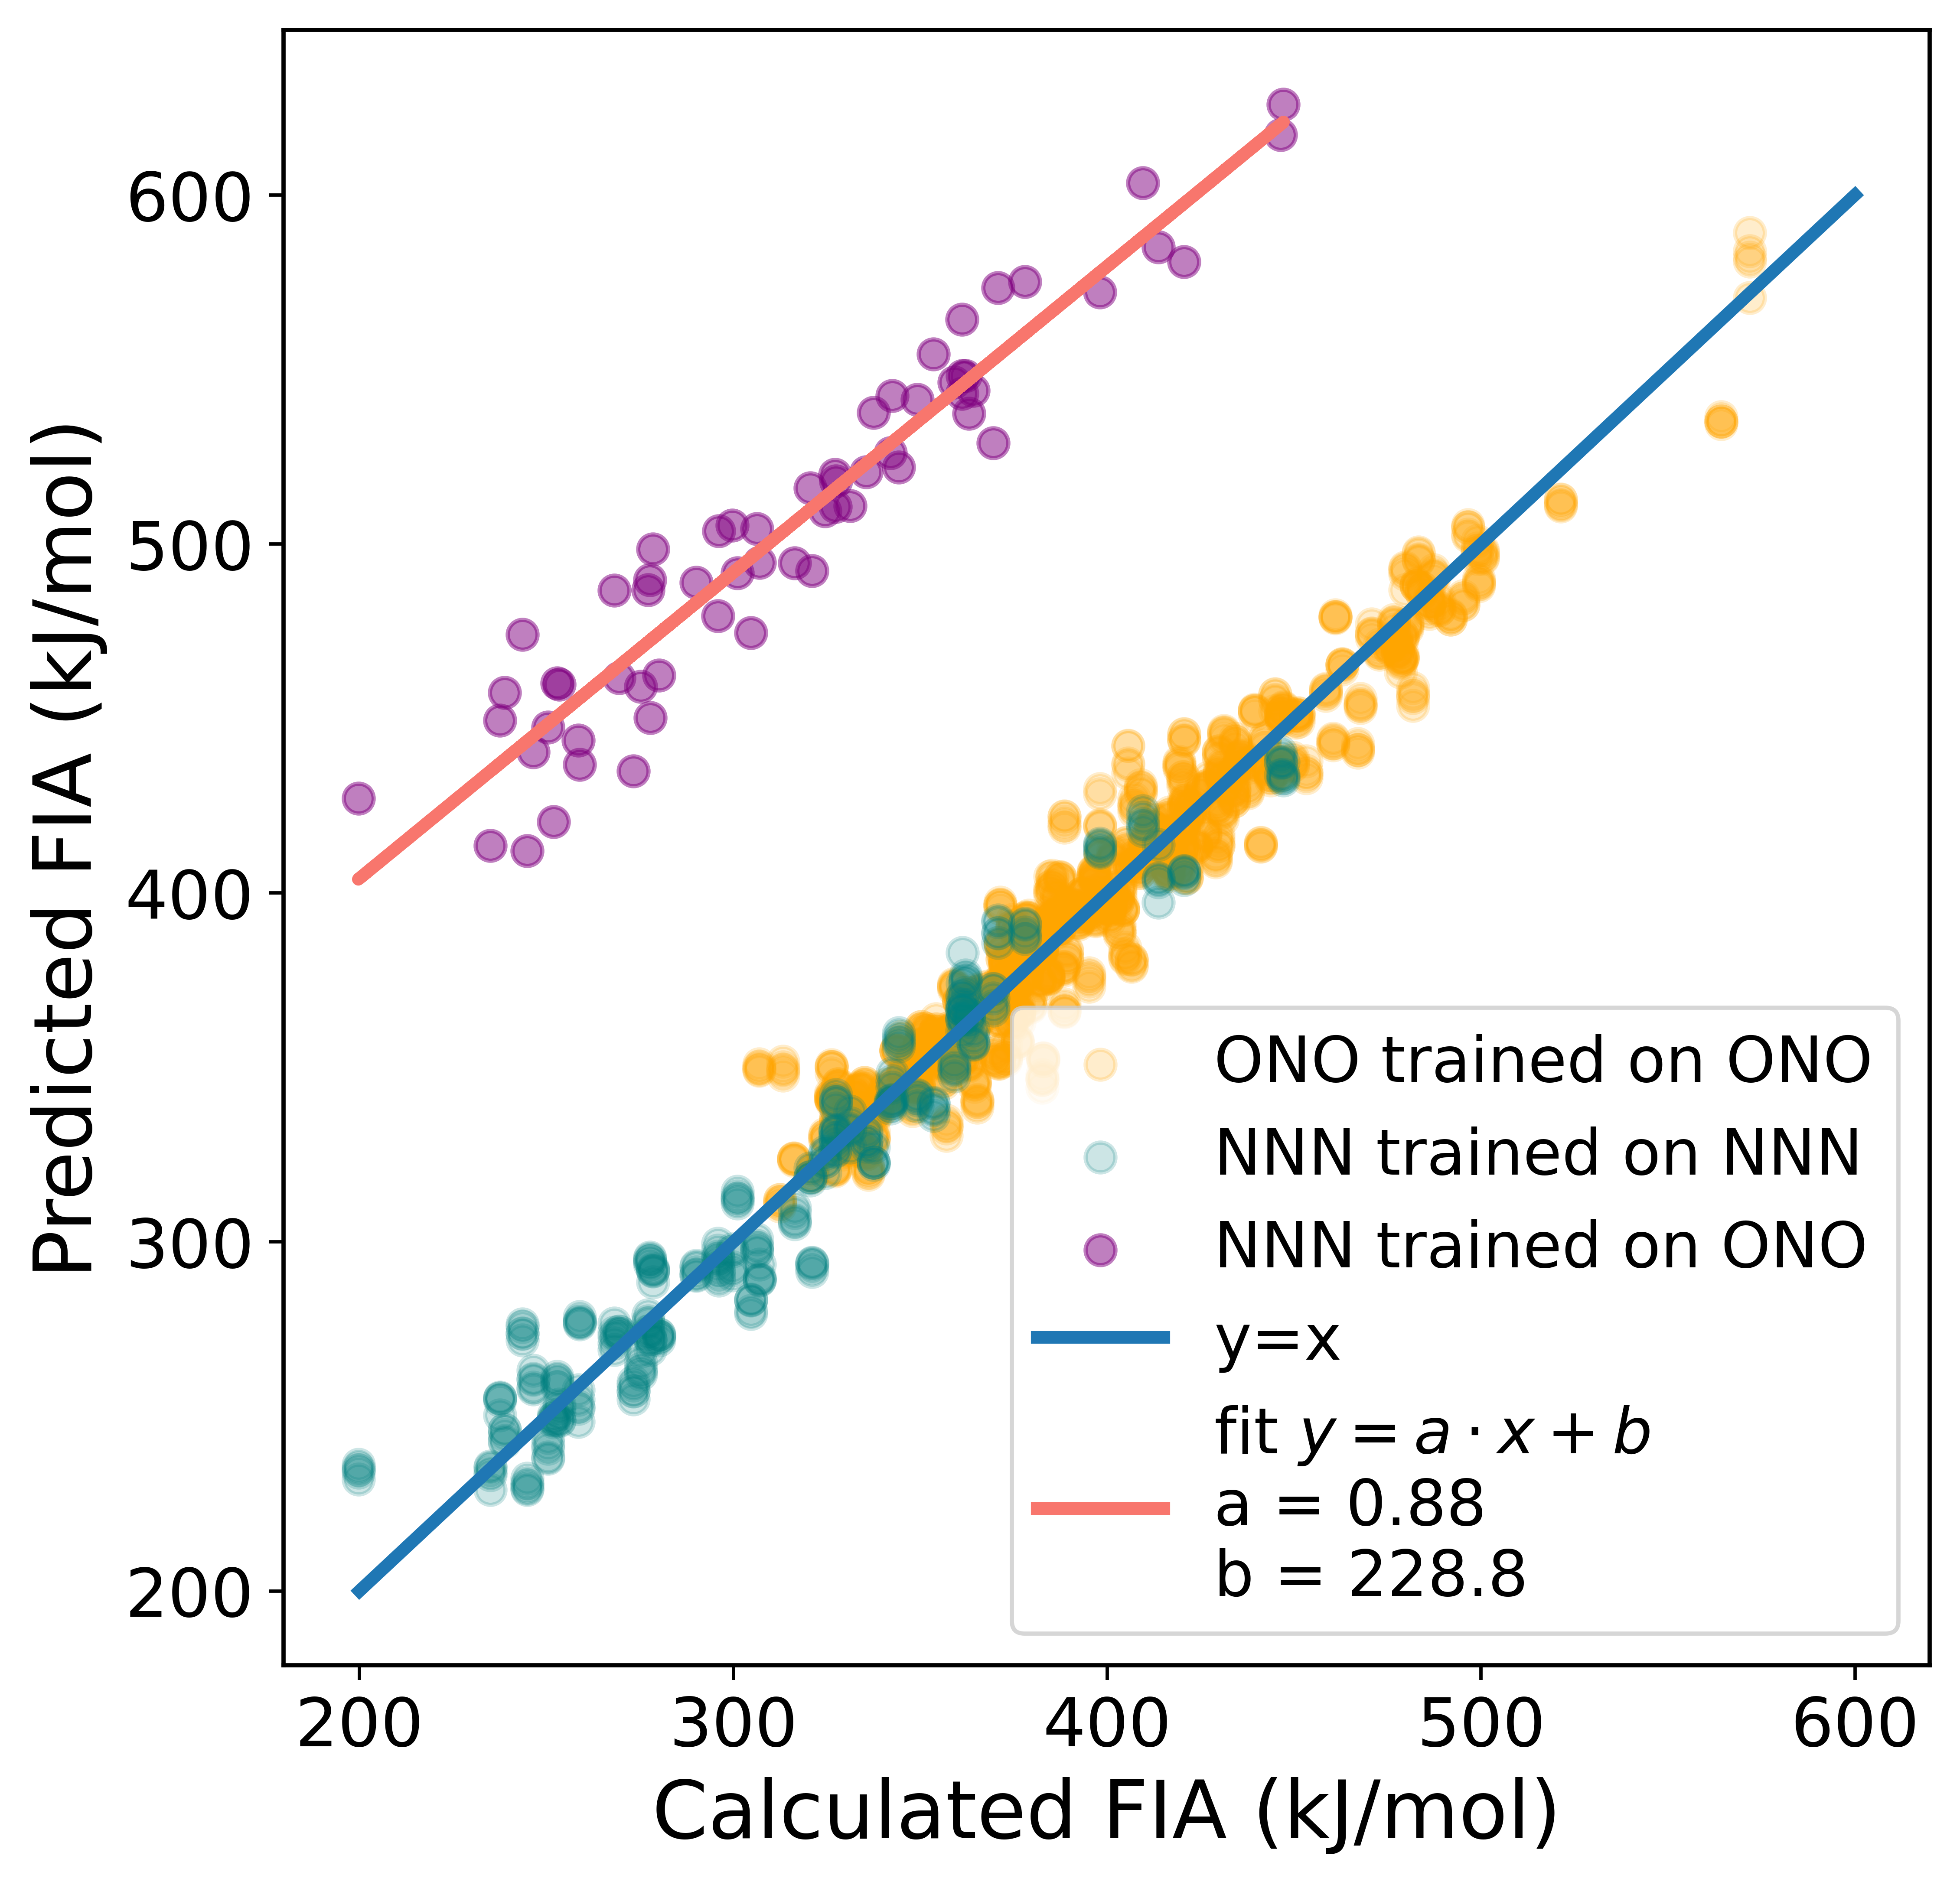

In [15]:
fig, ax1 = plt.subplots(figsize=(7, 7))

ax1.scatter(x=total_Y_S1_test, y=total_Y_S1_pred_test, s = 50, c="orange", alpha=0.2, label =f'{S1} trained on {S1}')
ax1.scatter(x=total_Y_S2_test, y=total_Y_S2_pred_test, s = 50, c="teal", alpha=0.2, label=f'{S2} trained on {S2}')
ax1.scatter(x=Y_S2, y=Y_pred_S2_train_S1,c = 'purple', s = 50, alpha=0.5, label=f'{S2} trained on {S1}')
#plt.scatter(x = FIA_ONO_reduced, y = FIA_ONO_reduced, s = 80, c='g')
intervalle = np.linspace(200, 600, 100)
ax1.plot(intervalle, intervalle, label = "y=x")

z = np.polyfit(Y_S2, Y_pred_S2_train_S1, 1)
p = np.poly1d(z)
    
ax1.plot(Y_S2,p(Y_S2),"#F8766D", label = f"fit $y=a \cdot x+b$ \na = {round(z[0],2)} \nb = {round(z[1],2)}")

ax1.set_ylabel('Predicted FIA (kJ/mol)')
ax1.set_xlabel('Calculated FIA (kJ/mol)')

#ax1.set_title('A.', loc='left', fontsize =10)
ax1.legend(loc = 'lower right')

fig.savefig('figures/poster/extrapolation_quantum_not_reduced.svg', format = 'svg', transparent= True, bbox_inches='tight')

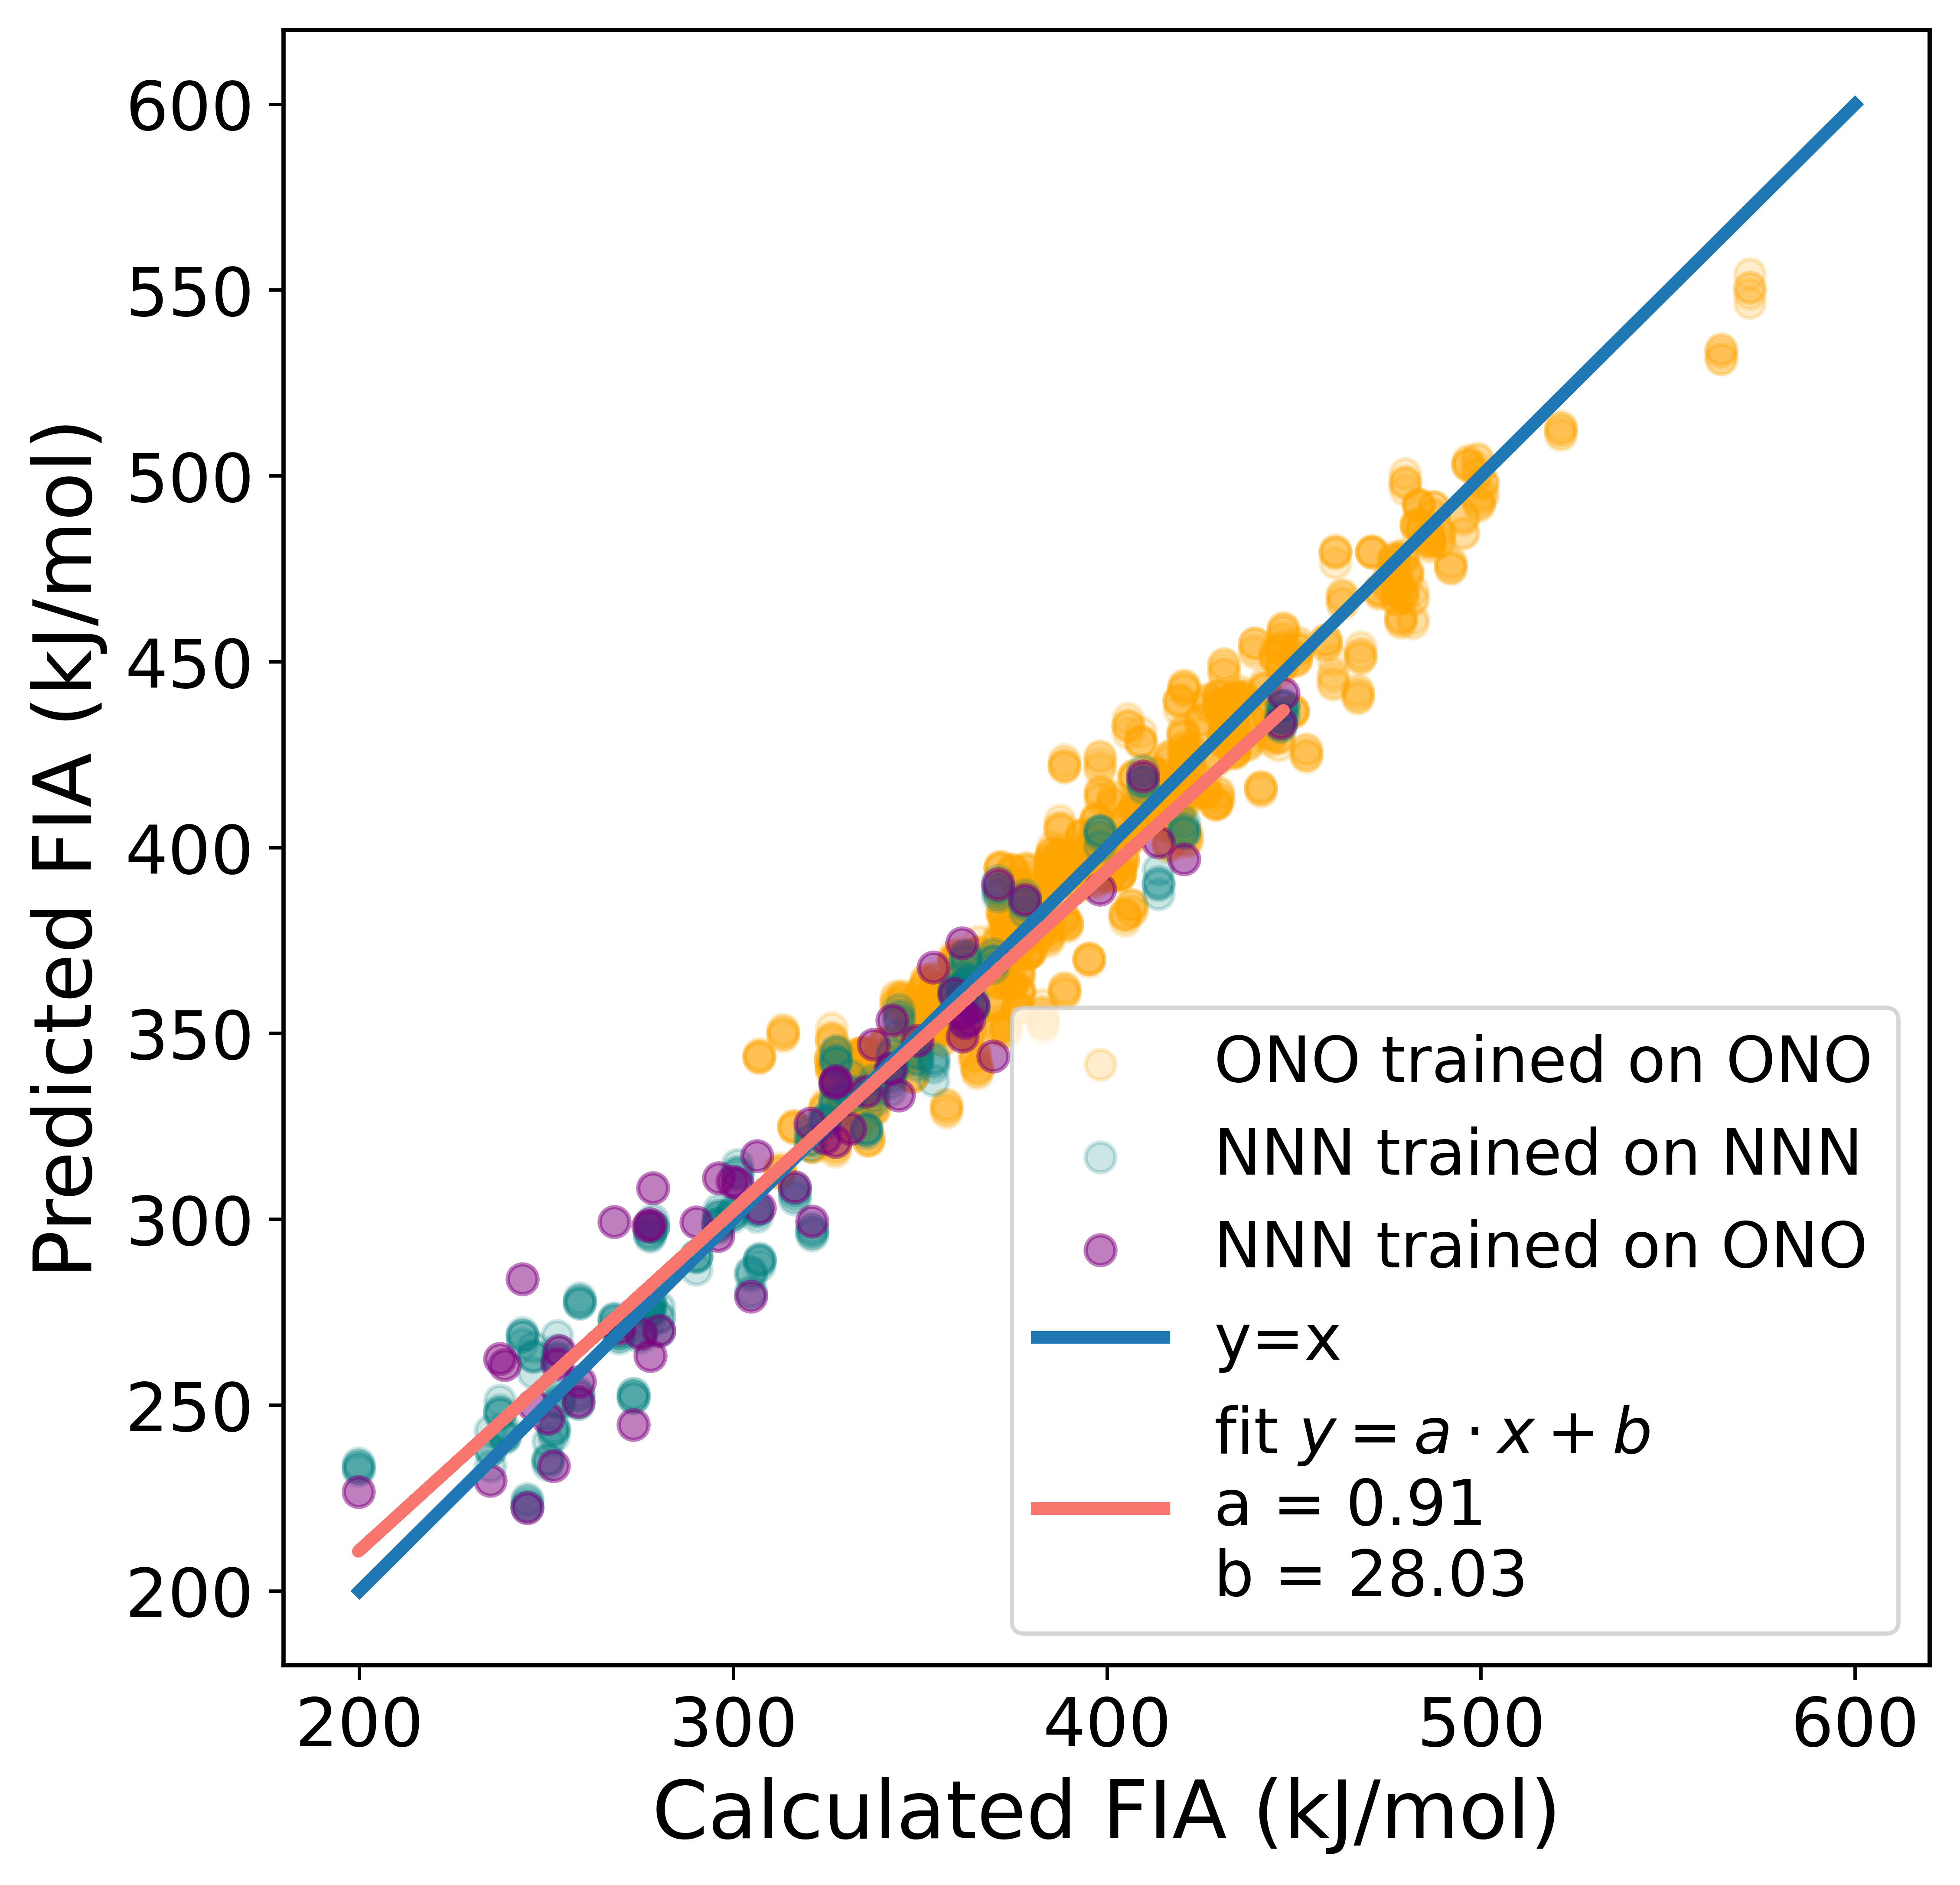

In [16]:
fig, ax2 = plt.subplots(figsize=(7, 7))

ax2.scatter(x=total_Y_S1_test_reduced, y=total_Y_S1_pred_test_reduced, s = 50, c="orange", alpha=0.2, label =f'{S1} trained on {S1}')
ax2.scatter(x=total_Y_S2_test_reduced, y=total_Y_S2_pred_test_reduced, s = 50, c="teal", alpha=0.2, label=f'{S2} trained on {S2}')
ax2.scatter(x=Y_S2, y=Y_pred_S2_train_S1_reduced,c = 'purple', s = 50, alpha=0.5, label=f'{S2} trained on {S1}')
#plt.scatter(x = FIA_ONO_reduced, y = FIA_ONO_reduced, s = 80, c='g')
intervalle = np.linspace(200, 600, 100)
ax2.plot(intervalle, intervalle, label = "y=x")

z = np.polyfit(Y_S2, Y_pred_S2_train_S1_reduced, 1)
p = np.poly1d(z)
    
ax2.plot(Y_S2,p(Y_S2),"#F8766D", label = f"fit $y=a \cdot x+b$ \na = {round(z[0],2)} \nb = {round(z[1],2)}")

ax2.set_ylabel('Predicted FIA (kJ/mol)')
ax2.set_xlabel('Calculated FIA (kJ/mol)')

#ax2.set_title('B.', loc='left', fontsize =10)
ax2.legend(loc = 'lower right')
,
fig.savefig('figures/poster/extrapolation_quantum_reduced.svg', format = 'svg', transparent= True, bbox_inches='tight')

#### RDKit descriptors

In [47]:
descriptors = "rdkit"
S1 = 'ONO'
S2 = 'NNN'

names = get_names(descriptors)

reduced_features=names[:]
reduced_features.remove('FractionCSP3')
reduced_features.remove('BCUT2D_CHGHI')
reduced_features.remove('MinEStateIndex')
reduced_features.remove('SlogP_VSA2')



## create descriptors

X_S1, X_S1_reduced, Y_S1 = reduce_descr(S1, descriptors, names, reduced_features)
X_S2, X_S2_reduced, Y_S2 = reduce_descr(S2, descriptors, names, reduced_features)

In [48]:
np.shape(X_S1_reduced)

(272, 204)

In [49]:
model = 'Ridge'

reduced = 'False'

def gene_X_S1(reduced):
    if reduced == 'True':
        return(X_S1_reduced)
    else :
        return(X_S1)

def gene_X_S2(reduced):
    if reduced == 'True':
        return(X_S2_reduced)
    else :
        return(X_S2)
       
X_S1_extr = gene_X_S1(reduced)
X_S2_extr = gene_X_S2(reduced)

total_Y_S1_test, total_Y_S1_pred_test, list_MAE_S1 = K_Fold_model_evaluation(dict_models[model][descriptors],X_S1_extr,Y_S1,n_fold=10, n_repet=5)
total_Y_S2_test, total_Y_S2_pred_test, list_MAE_S2 = K_Fold_model_evaluation(dict_models[model][descriptors],X_S2_extr,Y_S2,n_fold=10, n_repet=5)


#extrapolation avec les features reduced

Y_pred_S2_train_S1, MAE_S1_S2 = train_predict(X_S1_extr, X_S2_extr, Y_S1, Y_S2, dict_models[model][descriptors])

print(f"MAE {S1} = {round(np.mean(list_MAE_S1),2)}")
print(f"MAE {S2} = {round(np.mean(list_MAE_S2),2)}")
print(f"MAE {S1}->{S2} = {round(MAE_S1_S2,2)}")

MAE ONO = 6.92
MAE NNN = 10.43
MAE ONO->NNN = 1827.56


In [50]:
model = 'Ridge'

reduced = 'True'

def gene_X_S1(reduced):
    if reduced == 'True':
        return(X_S1_reduced)
    else :
        return(X_S1)

def gene_X_S2(reduced):
    if reduced == 'True':
        return(X_S2_reduced)
    else :
        return(X_S2)
       
X_S1_extr = gene_X_S1(reduced)
X_S2_extr = gene_X_S2(reduced)

total_Y_S1_test_reduced, total_Y_S1_pred_test_reduced, list_MAE_S1 = K_Fold_model_evaluation(dict_models[model][descriptors],X_S1_extr,Y_S1,n_fold=10, n_repet=5)
total_Y_S2_test_reduced, total_Y_S2_pred_test_reduced, list_MAE_S2 = K_Fold_model_evaluation(dict_models[model][descriptors],X_S2_extr,Y_S2,n_fold=10, n_repet=5)


#extrapolation avec les features reduced

Y_pred_S2_train_S1_reduced, MAE_S1_S2 = train_predict(X_S1_extr, X_S2_extr, Y_S1, Y_S2, dict_models[model][descriptors])

print(f"MAE {S1} = {round(np.mean(list_MAE_S1),2)}")
print(f"MAE {S2} = {round(np.mean(list_MAE_S2),2)}")
print(f"MAE {S1}->{S2} = {round(MAE_S1_S2,2)}")

MAE ONO = 7.05
MAE NNN = 10.32
MAE ONO->NNN = 9.05


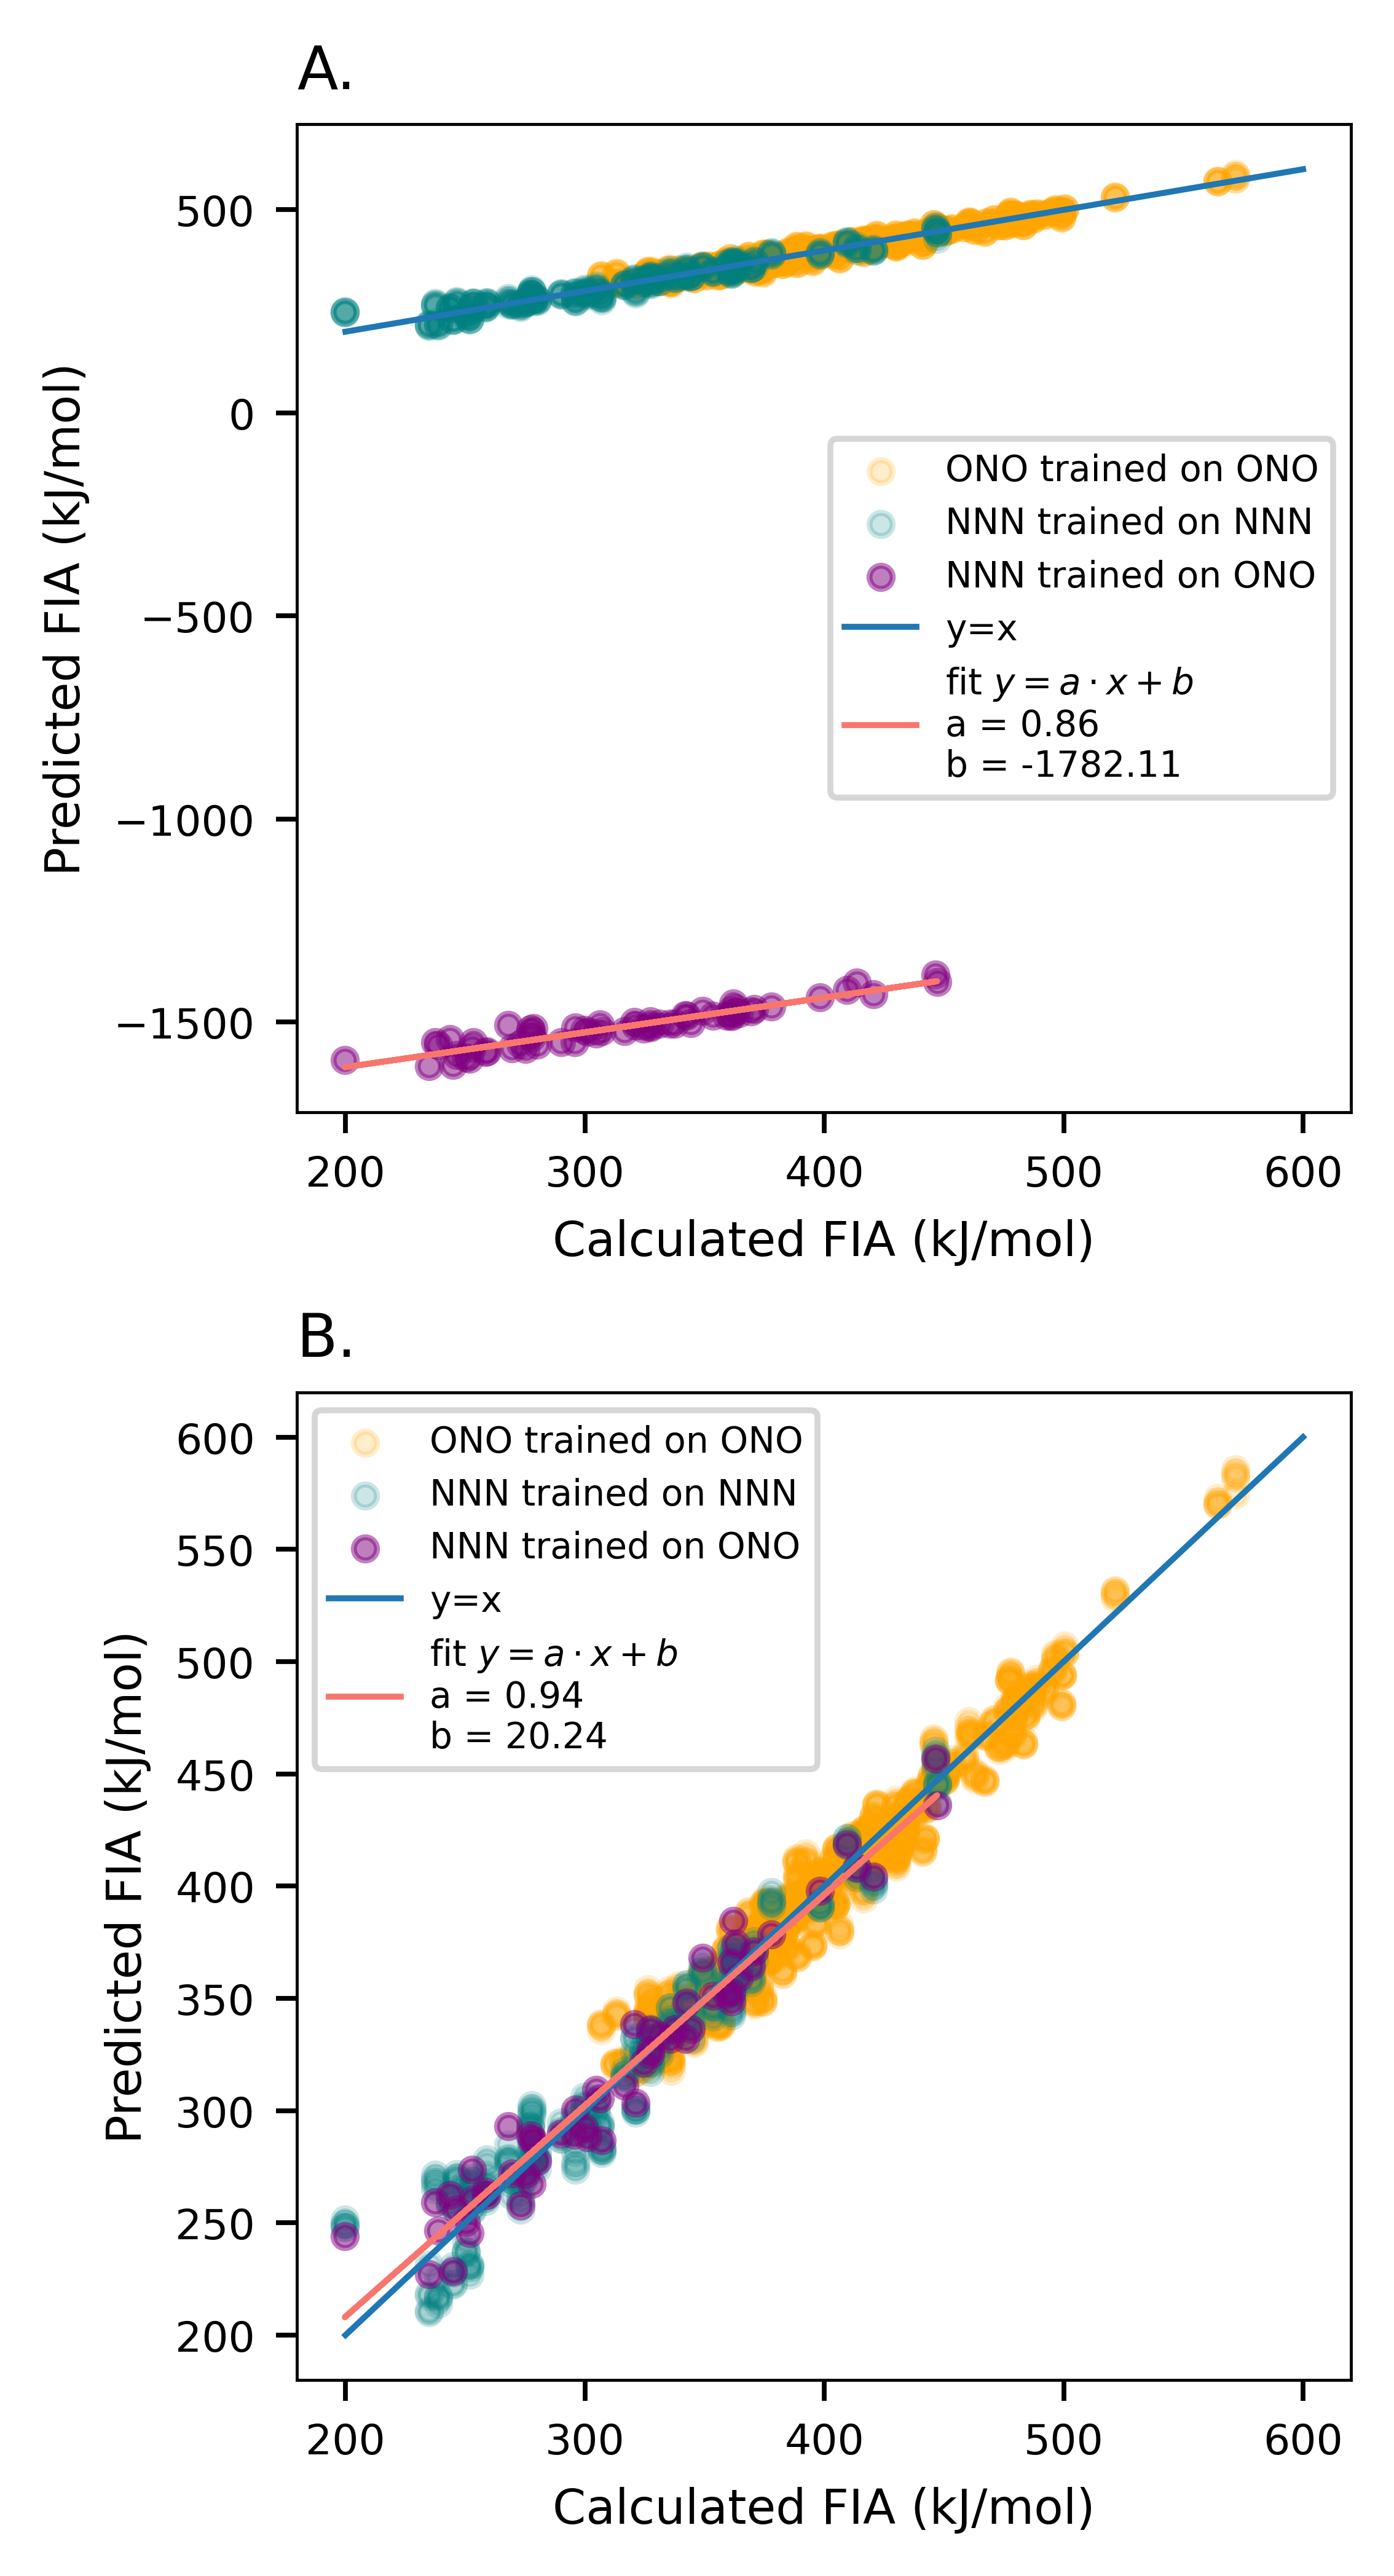

In [51]:
## plot 
fig = plt.figure(figsize=(3.25, 6))

ax1 = plt.subplot2grid((2, 1), (0, 0))

ax2 = plt.subplot2grid((2, 1), (1, 0))


## 1st graph

ax1.scatter(x=total_Y_S1_test, y=total_Y_S1_pred_test, s = 15, c="orange", alpha=0.2, label =f'{S1} trained on {S1}')
ax1.scatter(x=total_Y_S2_test, y=total_Y_S2_pred_test, s = 15, c="teal", alpha=0.2, label=f'{S2} trained on {S2}')
ax1.scatter(x=Y_S2, y=Y_pred_S2_train_S1,c = 'purple', s = 15, alpha=0.5, label=f'{S2} trained on {S1}')
#plt.scatter(x = FIA_ONO_reduced, y = FIA_ONO_reduced, s = 80, c='g')
intervalle = np.linspace(200, 600, 100)
ax1.plot(intervalle, intervalle, label = "y=x")

z = np.polyfit(Y_S2, Y_pred_S2_train_S1, 1)
p = np.poly1d(z)
    
ax1.plot(Y_S2,p(Y_S2),"#F8766D", label = f"fit $y=a \cdot x+b$ \na = {round(z[0],2)} \nb = {round(z[1],2)}")

ax1.set_ylabel('Predicted FIA (kJ/mol)')
ax1.set_xlabel('Calculated FIA (kJ/mol)')

ax1.set_title('A.', loc='left', fontsize =10)
ax1.legend()


## 2nd graph

ax2.scatter(x=total_Y_S1_test_reduced, y=total_Y_S1_pred_test_reduced, s = 15, c="orange", alpha=0.2, label =f'{S1} trained on {S1}')
ax2.scatter(x=total_Y_S2_test_reduced, y=total_Y_S2_pred_test_reduced, s = 15, c="teal", alpha=0.2, label=f'{S2} trained on {S2}')
ax2.scatter(x=Y_S2, y=Y_pred_S2_train_S1_reduced,c = 'purple', s = 15, alpha=0.5, label=f'{S2} trained on {S1}')
#plt.scatter(x = FIA_ONO_reduced, y = FIA_ONO_reduced, s = 80, c='g')
intervalle = np.linspace(200, 600, 100)
ax2.plot(intervalle, intervalle, label = "y=x")

z = np.polyfit(Y_S2, Y_pred_S2_train_S1_reduced, 1)
p = np.poly1d(z)
    
ax2.plot(Y_S2,p(Y_S2),"#F8766D", label = f"fit $y=a \cdot x+b$ \na = {round(z[0],2)} \nb = {round(z[1],2)}")

ax2.set_ylabel('Predicted FIA (kJ/mol)')
ax2.set_xlabel('Calculated FIA (kJ/mol)')

ax2.set_title('B.', loc='left', fontsize =10)
ax2.legend()

plt.tight_layout()

plt.show()

fig.savefig(f'article/figures/extrapolation_CV_Ridge_reduced_rdkit.png', facecolor = 'white', format = 'png', transparent = True, bbox_inches='tight')